In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-1.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-2.csv
/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-3.csv


In [2]:
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt

# Prepare Data

## Import

In [4]:
# Write a wrangle function

def wrangle(filepath):
    # Read csv files into DataFrame
    df=pd.read_csv(filepath)
    
    # Subset to properties in Distrito Federal
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    
    # Subset to apartment
    mask_apt=df["property_type"]=="apartment"
    
    # Subset to properties where price usd <300_000
    mask_price=df["price_aprox_usd"]<300_000
    # Subset
    df=df[mask_ba & mask_apt & mask_price]
    
    # Remove outliers by "surface_covered_in_m2"
    low, high=df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area=df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]
    
    # split "lat-lon" column
    df[["lat", "lon"]]=df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    df.drop(columns=["Unnamed: 0"],inplace=True)
    
    return df

In [5]:
# Create a DataFrame df

frame1 = wrangle("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-5.csv")
print(frame1.info())
frame1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1788 entries, 1 to 4618
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1788 non-null   object 
 1   property_type               1788 non-null   object 
 2   place_with_parent_names     1788 non-null   object 
 3   price                       1788 non-null   float64
 4   currency                    1788 non-null   object 
 5   price_aprox_local_currency  1788 non-null   float64
 6   price_aprox_usd             1788 non-null   float64
 7   surface_total_in_m2         262 non-null    float64
 8   surface_covered_in_m2       1788 non-null   float64
 9   price_usd_per_m2            157 non-null    float64
 10  price_per_m2                1788 non-null   float64
 11  floor                       0 non-null      float64
 12  rooms                       7 non-null      float64
 13  expenses                    0 non

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
1,sell,apartment,|Benito Juárez|Distrito Federal|México|,1570000.0,MXN,1556166.19,82737.39,NaN,75.0,NaN,20933.333330,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/raei_ven...,19.362690,-99.150565
2,sell,apartment,|Benito Juárez|Distrito Federal|México|,2700000.0,MXN,2675574.95,142253.50,NaN,92.0,NaN,29347.826090,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/odmz_ven...,19.399120,-99.141464
3,sell,apartment,|Tlalpan|Distrito Federal|México|,1370000.0,MXN,1357928.55,72197.60,NaN,62.0,NaN,22096.774190,NaN,NaN,NaN,http://tlalpan.properati.com.mx/r1ho_venta_dep...,19.291345,-99.124312
4,sell,apartment,|Iztapalapa|Distrito Federal|México|,840400.0,MXN,832797.49,44277.72,NaN,85.0,NaN,9887.058824,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/px1c_venta_...,19.354987,-99.061709
6,sell,apartment,|Benito Juárez|Distrito Federal|México|,3671744.0,MXN,3639391.14,193497.15,NaN,56.0,NaN,65566.857140,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qwmb_ven...,19.393650,-99.147690


In [6]:
# Use revised wrangle function create a DataFrames frame2.

frame2 = wrangle("/kaggle/input/maxico-housing-price-dataset/mexico-city-real-estate-4.csv")

In [7]:
# Use pd.concat to concatenate frame1 and frame2 into a new DataFrame df

df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   3560 non-null   object 
 1   property_type               3560 non-null   object 
 2   place_with_parent_names     3560 non-null   object 
 3   price                       3560 non-null   float64
 4   currency                    3560 non-null   object 
 5   price_aprox_local_currency  3560 non-null   float64
 6   price_aprox_usd             3560 non-null   float64
 7   surface_total_in_m2         513 non-null    float64
 8   surface_covered_in_m2       3560 non-null   float64
 9   price_usd_per_m2            302 non-null    float64
 10  price_per_m2                3560 non-null   float64
 11  floor                       0 non-null      float64
 12  rooms                       16 non-null     float64
 13  expenses                    0 non

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Benito Juárez|Distrito Federal|México|,1570000.0,MXN,1556166.19,82737.39,NaN,75.0,NaN,20933.333330,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/raei_ven...,19.362690,-99.150565
1,sell,apartment,|Benito Juárez|Distrito Federal|México|,2700000.0,MXN,2675574.95,142253.50,NaN,92.0,NaN,29347.826090,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/odmz_ven...,19.399120,-99.141464
2,sell,apartment,|Tlalpan|Distrito Federal|México|,1370000.0,MXN,1357928.55,72197.60,NaN,62.0,NaN,22096.774190,NaN,NaN,NaN,http://tlalpan.properati.com.mx/r1ho_venta_dep...,19.291345,-99.124312
3,sell,apartment,|Iztapalapa|Distrito Federal|México|,840400.0,MXN,832797.49,44277.72,NaN,85.0,NaN,9887.058824,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/px1c_venta_...,19.354987,-99.061709
4,sell,apartment,|Benito Juárez|Distrito Federal|México|,3671744.0,MXN,3639391.14,193497.15,NaN,56.0,NaN,65566.857140,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qwmb_ven...,19.393650,-99.147690


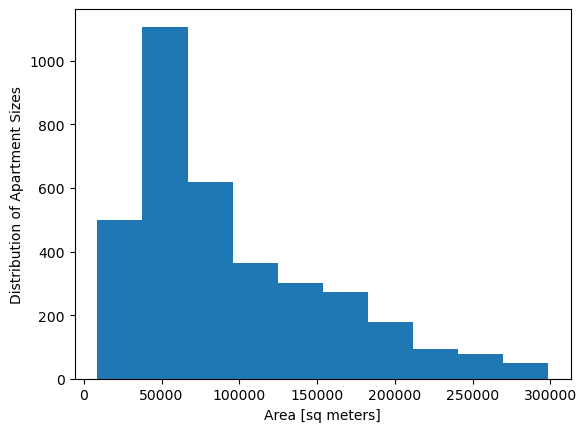

In [8]:
# Create a histogram of "surface_covered_in_m2"
plt.hist(df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Distribution of Apartment Sizes");

## Explore

In [9]:
#  create a Mapbox scatter plot that shows the location of the apartments

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,  
    height=600, 
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

In [10]:
# Create features matrix

features = ["lat", "lon"]
X_train = df[features]
X_train.head()

,lat,lon
0,19.362690,-99.150565
1,19.399120,-99.141464
2,19.291345,-99.124312
3,19.354987,-99.061709
4,19.393650,-99.147690


In [11]:
#Create the target vector named y_train

target = "price_aprox_usd"
y_train = df[target]
y_train.head()

0     82737.39
1    142253.50
2     72197.60
3     44277.72
4    193497.15
Name: price_aprox_usd, dtype: float64

# Build Model

## Baseline

In [12]:
# Calculate the mean of your target vector y_train and assign it to the variable y_mean

y_mean =y_train.mean()
y_mean

95039.3129522472

In [13]:
# Create a list named y_pred_baseline that contains the value of y_mean repeated so that it's the same length at y

y_pred_baseline = [y_mean]*len(y_train)
y_pred_baseline[:5]

[95039.3129522472,
 95039.3129522472,
 95039.3129522472,
 95039.3129522472,
 95039.3129522472]

In [14]:
# Calculate the baseline mean absolute error

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 95039.31
Baseline MAE: 50644.56


## Iterate

In [15]:
imputer = SimpleImputer()

In [16]:
imputer.fit(X_train)

SimpleImputer()

In [17]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     3560 non-null   float64
 1   lon     3560 non-null   float64
dtypes: float64(2)
memory usage: 55.8 KB


In [18]:
#  Create a pipeline

model = make_pipeline(
    SimpleImputer(),
    LinearRegression(),
)

In [19]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

## Evaluate

In [20]:
# create a list of predictions for the observations for feature matrix X_train

y_pred_training = model.predict(X_train)

In [21]:
# Calculate the training mean absolute error

mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 46496.93


## Communicate resluts

In [22]:
# Extract the intercept and coefficients for the model
intercept = model.named_steps["linearregression"].intercept_.round()
coefficients = model.named_steps["linearregression"].coef_.round()
coefficients

array([-238789., -314562.])

In [23]:
# Print the equation
print(
    f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)"
)

price = -26465335.0 + (-238789.0 * longitude) + (-314562.0 * latitude)
